In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random as rd
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (7,4)

Simulation de systèmes dynamiques non lisses
==============================


Le cours se focalise sur l'étude de systèmes dynamiques réguliers, c'est-à-dire $\dot{x}=f(x)$ avec $f$ au moins continue, et le plus souvent continûment différentiable. Le but de ce projet est de découvrir des systèmes moins réguliers, dits *non-lisses*. Il existe une myriade de modélisations de ces systèmes mais on peut distinguer différents *niveaux* d'irrégularité:

 - $f$ est continue mais non différentiable en certains points (on parle de *nonsmooth dynamics of type 1*, i.e., *NSD1*) : cela peut arriver dans la modélisation d'écoulements par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ restent $C^1$ mais leur simulation peut déjà se compliquer.

 - $f$ est discontinue en certains points, ou le long de certaines surfaces (on parle de *NSD2*) : ceci apparaît typiquement en mécanique lors de la modélisation de contacts et friction entre solides, ou dans la modélisation de circuits électriques contenant des diodes par exemple. Dans ce cas, les solutions $t\mapsto x(t)$ sont toujours (absolument) continues mais non différentiables, le schéma numérique doit détecter des changements de *mode*.

 - les solutions $t\mapsto x(t)$ sont elles-mêmes discontinues, présentant des *sauts*  à certains instants ou lorsqu'elles rencontrent certaines surfaces, et il faut ajouter à $f$ un modèle de ces sauts (on parle de *NSD3*) : ceci apparaît typiquement avec les systèmes mécaniques à impact.

L'étude mathématique de ces sytèmes est très complexe, faisant appel à des outils qui nous mèneraient trop loin de ce cours (inclusions différentielles, complémentarité, analyse convexe, *measure differential inclusions*, etc), notre but est seulement d'en découvrir certains aspects à travers des exemples iconiques. Les curieux peuvent se référer à la documentation fournie par 

https://www.inria.fr/en/modelling-mechanics-simulation-fibres

https://www.inria.fr/en/tripop

ou aux ouvrages de références tels que

https://link.springer.com/book/10.1007/978-94-015-7793-9

https://link.springer.com/book/10.1007/978-3-540-44398-8 




## Dynamique non différentiable (NSD1)

Reprenons la loi de Toriccelli étudiée en TD et modélisant (modulo reparamétrisation) l'écoulement d'un fluide dans un réservoir
$$
\dot{x} = - \sqrt{|x|} \tag{1}
$$

**Question 1** Coder un schéma Euler explicite permettant de simuler une équation différentielle $\dot{x}=f(x,t)$ à partir d'une condition initiale $x_0$ au temps $t_0$ jusqu'au temps $t_f$ avec un pas de temps $dt$. 

In [2]:
def euler_explicit(f,x0,t0,tf,dt):
    time = [t0]  # on initialise l'abscisse des temps
    sol = [x0]  # idem pour valeurs de la solution d'Euler

    while time[-1] <= tf - dt:
        tn = time[-1]
        xn = sol[-1]

        time.append(tn + dt)  # on ajoute tn+1
        sol.append(xn + f(xn,tn) * dt)  # idem pour xn+1
    
    return time, sol

---

**Question 2** L'utiliser pour simuler un écoulement d'une hauteur initiale $x_0=10$ pendant 10 unités de temps. Tracer la solution obtenue. Est-elle celle que l'on attend ? Les solver ''odeint'' ou ''solve_ivp" de scipy fait-il mieux ? Expliquer pourquoi. Proposer une façon de simuler *la* solution *physique*.



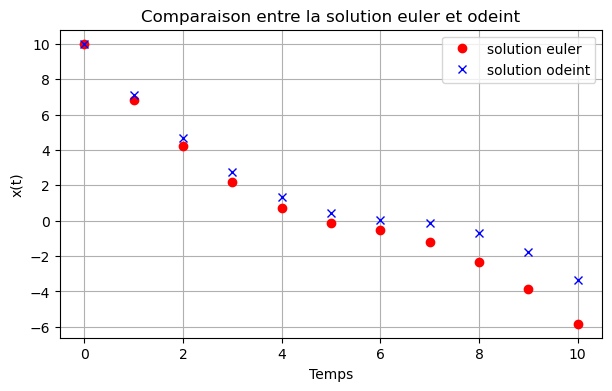

In [3]:
def f(x,t):
    return -(abs(x))**0.5  # cf loi de Toricelli

x0 = 10
t0 = 0
tf = 10
dt = 1

time, sol = euler_explicit(f,x0,t0,tf,dt)
sol_odeint = odeint(f, x0, time)

plt.plot(time, sol, 'ro', label='solution euler')
plt.plot(time, sol_odeint, 'bx', label='solution odeint')

# Mise en forme du graphique
plt.xlabel('Temps')
plt.ylabel('x(t)')
plt.title('Comparaison entre la solution euler et odeint')
plt.legend()
plt.grid(True)

Les solvers de scipy font bien mieux que la méthode d'Euler car ils ne font pas des approximations d'ordre 1 et qu'ils ont un pas de temps adaptatif (alors que le pas de temps de la méthode d'Euler est fixe).

Pour simuler la solution physique, il suffit de prendre $x_0 \geq 0$

---

En pratique, on essaye toujours de se ramener à une modélisation *bien posée* dont les solutions existent et sont uniques (ajout de contraintes ou régularisation, par exemple). Ici, on pourrait par exemple considérer plutôt
$$
\dot{x} = - {\rm sign}(x) \sqrt{|x|} \tag{2}
$$
avec ${\rm sign}(0)$ arbitraire. 

**Question 3** Montrer que pour toute condition initiale dans $\mathbb{R}$, (2) admet une unique solution maximale en temps positif définie sur $\mathbb{R}_{\geq 0}$, et qu'elle correspond à la solution ``physique'' attendue précédemment pour des conditions initiales positives. Justifier que l'on parle de "convergence globale vers 0 en temps fini". Illustrer ce phénomène en simulation. Ce comportement serait-il possible pour $\dot{x}=f(x)$ avec $f$ continûment différentiable ?

1. Existence et unicité d'une solution maximale

Soit $x_{0} \in \mathbb{R}$ (la condition initiale)

Tout d'abord, puisque $f$ est continue ( $\lim_{x \to 0} \sqrt{|x|} = 0$ ), par le théorème de Peano-Arzelà et le théorème de domaine d'existence maximale : il existe une solution maximale au problème de Cauchy.


Si $x_0 = 0$, montrons que $x(t) = 0$ :

Raisonnons par l'absurde : $\exists t_0 > 0$, $x(t_0) \neq 0$

Si $x(t_0) > 0$ : or $x$ est continue (car dérivable cf (2)) et $\dot{x}$ bien défini, donc $\exists t_1, \dot{x}(t_1) > 0$ où $x(t_1) > 0$. Ceci est absurde car (2) assure que $\dot{x}(t_1) < 0$
        
Idem pour $x(t_0) < 0$

Donc $\forall t \geq 0$, $x(t) = 0$.

Maintenant, si $x_0 > 0$ (resp.$x_0 < 0$), (2) assure que $x$ est décroissante (resp. croissante).

Tant que  $x(t) \neq 0$ : $f$ est $C^1$. Par le théorème de Cauchy-Lipschitz, il existe une unique solution maximale sur cet intervalle.

Et si $x$ atteint 0, alors la solution reste nulle par ce qui précède.

La solution est donc unique.

Elle correpond à la solution physique, car lorsque $x$ atteint 0 (le tonneau s'est vidé), la solution reste nulle (le niveau ne devient pas négatif).

2. Convergence globales vers 0

On vérifie facilement que cette fonction est la solution maximale : $$x(t) = \begin{cases} {\rm sign}(x_0) \left( \sqrt{|x_0|} - \frac{t}{2} \right)^2 & \text{si } t < 2\sqrt{|x_0|} \\ 0 & \text{si } t \geq 2\sqrt{|x_0|} \end{cases}$$

On comprend donc le caractère de convergence globale en temps fini, car toutes les solutions sont nulles après $2\sqrt{|x_0|}$

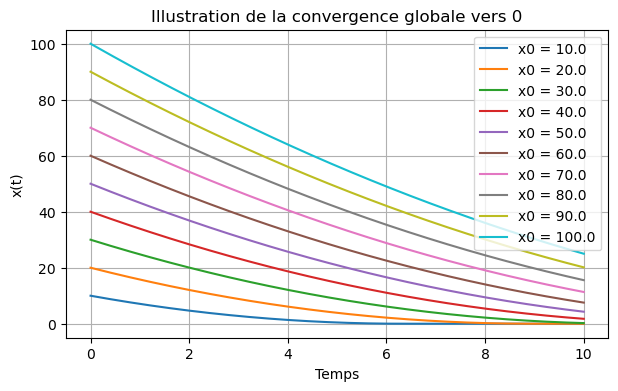

In [11]:
# Illustration graphique
def sign(x):
    if x>0:
        return 1
    elif x<0:
        return -1
    else:
        return 1
    
def f(x,t):
    return -sign(x)*(abs(x))**0.5

CI = np.linspace(10,100,10)  # liste des conditions initiales
time = np.linspace(0,10, 200)
for x0 in CI:
    sol_odeint = odeint(f, x0, time)
    plt.plot(time, sol_odeint, label='x0 = '+str(x0))

# Mise en forme du graphique
plt.xlabel('Temps')
plt.ylabel('x(t)')
plt.title('Illustration de la convergence globale vers 0')
plt.legend()
plt.grid(True)


Finalement, ce comportement de convergence globale vers n'est pas possible pour une fonction vérifiant $\dot{x} = f(x)$ avec $f$ continûment différentiable et $f(0) = 0$.

En effet par l'absurde, considérons une solution non nulle jusqu'à $T$, puis constamment nulle après.

Puisque $f$ continûment différentiable, $f$ est localement continue autour de $T$. Donc par le théorème de Peano-Arzelà, cette solution est localement unique.

Ceci est absurde car $x(t) = 0$ est aussi solution.

---

## Dynamique discontinue (NSD2)



Passons maintenant à une irrégularité plus forte, lorsque la fonction $f$ décrivant l'équation différentielle $\dot{x}=f(x)$ est discontinue, c'est-à-dire lorsque la solution $x$ suit des dynamiques différentes selon les régions de l'espace (par exemple selon le sens du courant pour des diodes, selon le sens de la vitesse pour des frottements secs etc.). Un exemple emblématique de ce cas de figure est 
$$
\dot{x} = - k {\rm sign}(x) \tag{3}
$$
pour $k>0$ et la valeur de ${\rm sign}(0)$ à définir. Dans ce contexte, on affaiblie la régularité des solutions recherchées, qui ne sont plus nécessairement $C^1$ sur leur intervalle de définition. Par contre, elles sont toujours censées vérifier l'équation intégrale 
$$
x(t) = x(t_0) + \int_{t_0}^t f(s,x(s)) ds
$$
et on considère donc la classe des solutions *absolument continues*, qui vérifient l'équation différentielle *pour presque tout $t$* seulement. 

**Question 4** Démontrer que pour une valeur de ${\rm sign}(0)$ bien choisie, (3) admet, pour toute condition initiale $x_0\in \mathbb{R}$, une unique solution maximale $t\mapsto x(t)$ en temps positif définie sur $\mathbb{R}_{\geq 0}$ et convergeant en temps fini vers 0. L'expliciter.

On choisit ${\rm sign}(0) = 0$.

Si $x_0 = 0$, on montre que l'unique solution est $x(t) = 0$ avec les mêmes arguments de continuité (car $x$ est dérivable) et d'absurdité du signe de la dérivée.

Ensuite, tant que $x(t) \neq 0$, en intégrant : $x(t) - x_0 = - k \ {\rm sign} (x_0) \ t$

Lorsque $x$ devient nulle, par ce qui précède, la solution reste nulle.

La solution générale est donc : $$x(t) = \begin{cases} x_0 - k \ {\rm sign} (x_0) \ t & \text{si } t < \frac{|x_0|}{k} \\ 0 & \text{si } t \geq \frac{|x_0|}{k} \end{cases}$$

Elle converge bien vers 0 en temps fini !

---

Considérons maintenant $\delta_m>0$ et l'équation différentielle perturbée
$$
\dot{x} = - k{\rm sign}(x) + \delta(t) \tag{4}
$$
pour $t\mapsto \delta(t)$ telle que $|\delta(t)|\leq \delta_m$ pour tout $t$.

**Question 5** Démontrer que si $k>\delta_m$, alors (4) admet toujours, pour toute condition initiale $x_0\in \mathbb{R}^*$ et quelle que soit la perturbation $\delta$ bornée par $\delta_m$, une unique solution maximale $t\mapsto x(t)$ en temps positif et convergeant en temps fini vers 0. Justifier que ces solutions pourraient être définie sur $\mathbb{R}_{\geq 0}$ si on acceptait que ${\rm sign}(0)$ puisse prendre n'importe quelle valeur entre -1 et 1.

1. Existence et unicité d'une solution maximale

Tant que $x(t) \neq 0$, $f$ est $C^1$ par rapport à $x$. Ainsi, on peut appliquer le théorème de Cauchy-Lipschitz, qui assure l'existence et l'unicite d'une solution maximale.

2. Convergence vers 0 en temps fini

Posons la fonction auxilliaire $g(x) = |x|$.

Or :
$\frac{d}{dt}|x(t)| = \dot{x}(t) \cdot {\rm sign}(x(t))$

Par (4) :
$\frac{d}{dt}|x(t)| = ( -k {\rm sign}(x) + \delta(t)) \ {\rm sign}(x)$

Puisque $({\rm sign}(x))^2 = 1$ pour $x \neq 0$ :
$\frac{d}{dt}|x(t)| = -k + \delta(t){\rm sign}(x)$

Comme $|\delta(t)| \leq \delta_m$ :
$\frac{d}{dt}|x(t)| \leq -k + \delta_m$

Posons $\varepsilon = k - \delta_m$. Puisque $k > \delta_m$ : $\varepsilon > 0$. On a donc :
$\frac{d}{dt}|x(t)| \leq -\varepsilon$

En intégrant cette inégalité entre $0$ et $t$ (tant que $x(t) \neq 0$) :
$|x(t)| - |x(0)| \leq -\varepsilon t$

Cad $|x(t)| \leq |x_0| - \varepsilon t$

Puisque $|x(t)| \geq 0$ : la trajectoire atteint nécessairement 0 en un temps fini $T$, tq : $T \leq \frac{|x_0|}{\varepsilon}$.

3. Prolongement solution sur $\mathbb{R}_{\geq 0}$

Une fois que la trajectoire atteint $x=0$, l'équation différentielle classique n'est plus définie car la fonction signe est discontinue. Pour étendre la solution à $\mathbb{R}_{\geq 0}$, on accepte que ${\rm sign}(0) \in [-1, 1]$.

On a donc :
$\dot{x} \in -k \cdot [-1, 1] + \delta(t)$

Pour que la solution reste nulle, on doit avoir : $0 = -k \ {\rm sign}(0) + \delta(t)$

D'où:
${\rm sign}(0) = \frac{\delta(t)}{k}$


Comme $|\delta(t)| \leq \delta_m < k$ : $\frac{|\delta(t)|}{k} < 1$

Donc on bien :
${\rm sign}(0) \in [-1, 1]$

---

Ceci mène en fait à la notion d'*inclusion différentielle* $\dot{x}\in f(x)$, où la fonction signe serait ici une fonction *multivaluée*, c'est-à-dire à valeurs ensembliste (*set-valued map*), définie par
$$
{\rm Sign}(x) = \left\{
\begin{array}{ll}
{1} & \text{si x>0} \\
[-1,1] & \text{si x=0} \\
-1 & \text{si x<0}
\end{array}
\right.
$$
Ce genre de phénomène est utilisé en commande ou estimation par *mode-glissant* (*sliding mode*) pour stabiliser des systèmes dynamiques en temps fini et malgré la présence de perturbations inconnues ou d'incertitudes dans le modèle. Le prix à payer pour ce genre de système est une grande sensibilité au bruit et une difficulté accrue de les discrétiser et simuler.

*Pour la culture* : La théorie des inclusions différentielles a été développée par Filippov, voir https://link.springer.com/book/10.1007/978-3-319-28664-8. Elle a montré que le ``bon'' cadre pour qu'une inclusion différentielle ait de bonnes propriétés (notamment que des approximations de solutions convergent vers des solutions, c'est-à-dire la compacité séquentielle des solutions, permettant la discrétisation et simulation de ces systèmes) est lorsque $f$ est semi-continue supérieure, localement bornée et à valeurs convexes et fermées. D'où l'intervalle $[-1,1]$ pour ${\rm sign}(0)$ qui est le plus petit convexe fermé assurant la semi-continuité supérieure de ${\rm sign}$. 


**Question 6** Illustrer numériquement la convergence en temps finie globale et la robustesse aux perturbations de (4) à l'aide du schéma numérique de votre choix.

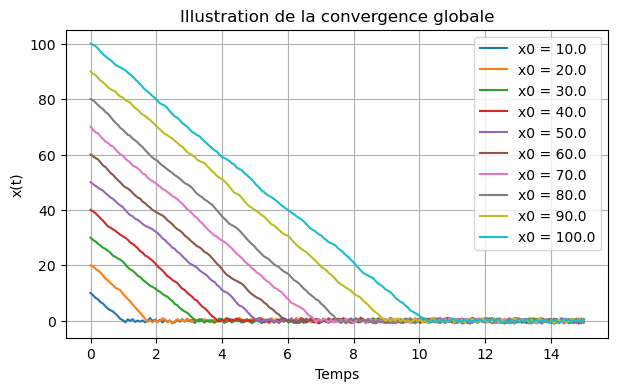

In [5]:
def sign(x):
    if x>=0: #Choix arbitraire pour sign(0)
        return 1
    else:
        return -1

def delta(t,dm):
    return rd.uniform(-dm,dm)

def f(x,t,k,dm):
    return -k*sign(x) + delta(t,dm)

### Convergence en temps fini

k = 10
dm = 5


CI = np.linspace(10,100,10)
time = np.linspace(0,15,200)
dt=time[1]-time[0]
x=0

for x0 in CI:
    sol = []
    x=x0
    for t in time:
        sol.append(x)
        x += dt*f(x,t,k,dm)
    plt.plot(time, sol, label='x0 = '+str(x0))

plt.xlabel('Temps')
plt.ylabel('x(t)')
plt.title('Illustration de la convergence globale')
plt.legend()
plt.grid(True)


### Robustesse aux perturbations






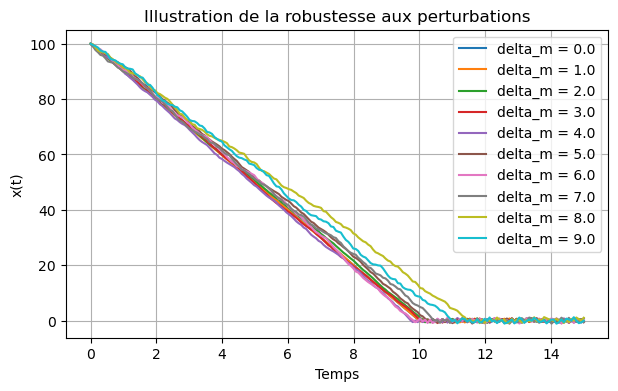

In [6]:
### Robustesse aux perturbations

k=10
x0=100
time = np.linspace(0,15,200)
Liste_dm = np.linspace(0,k,11)[:-1]

for dm in Liste_dm:
    x=x0
    sol = []
    for t in time:
        sol.append(x)
        x += dt*f(x,t,k,dm)
    plt.plot(time, sol, label='delta_m = '+str(dm))

plt.xlabel('Temps')
plt.ylabel('x(t)')
plt.title('Illustration de la robustesse aux perturbations')
plt.legend()
plt.grid(True)

---

**Question 7** Illustrer et commenter le comportement du schéma d'Euler explicite autour de 0. On parle de phénomène de chattering. Que se passe-t-il si $k$ est grand ? Proposer un schema d'Euler implicite pour ce système et montrer qu'il permet d'éviter ce *chattering* et d'assurer une convergence numérique exacte vers 0.


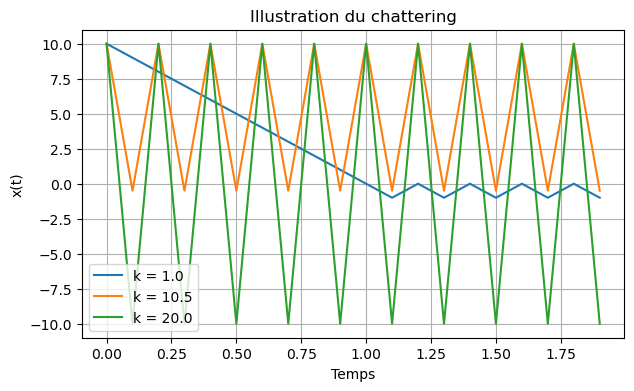

In [15]:
### Illustration chattering

def sign(x):
    if x>=0: #Choix arbitraire pour sign(0)
        return 1
    else:
        return -1


x0=10
t0=0
tf=2
dt=0.1

Liste_k=np.linspace(x0/10, 2*x0, 3)

def euler_explicite(x0,t0,tf,dt):
    time=np.arange(t0,tf,dt)
    sol=[]
    x=x0
    for t in time:
        sol.append(x)
        x+=-k*sign(x)
    return time, sol

for k in Liste_k:
    time,sol = euler_explicite(x0,t0,tf,dt)
    plt.plot(time, sol, label='k = '+str(k))

plt.xlabel('Temps')
plt.ylabel('x(t)')
plt.title('Illustration du chattering')
plt.legend()
plt.grid(True)

x(t) est censé s'annuler en croisant 0 mais le schéma d'Euler explicite vient compenser (avec la fonction signe) sur un pas discret et on oscille alors autour de 0 (phénomène de chattering). 

On remarque également que si k est grand devant x0, le bruit engendré est trop important pour pouvoir analyser la focntion (erreur de l'ordre de k)

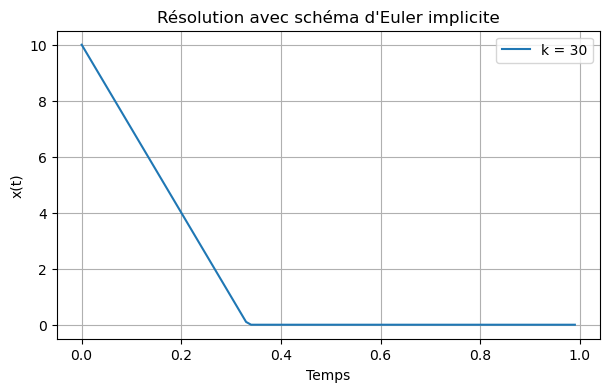

In [8]:
k=30
x0=10
t0=0
tf=1
dt=0.01

def euler_implicit_sliding(x0,t0,tf,dt):
    time = np.arange(t0,tf,dt)
    sol=[x0]
    x=x0
    for t in time[1:]:
        if x > k*dt:
            x -= k*dt
        elif x < -k*dt:
            x += k*dt
        else:
            x=0
        sol.append(x)

    return time, sol

time, sol = euler_implicit_sliding(x0,t0,tf,dt)
plt.plot(time, sol, label='k = '+str(k))

plt.xlabel('Temps')
plt.ylabel('x(t)')
plt.title("Résolution avec schéma d'Euler implicite")
plt.legend()
plt.grid(True)


---

**Question 8** Application : donner un exemple physique d'un oscillateur évoluant selon
$$
\begin{array}{rcl}
\dot{x}_1 &=& x_2 \\
\dot{x}_2 &=& -x_1 - k {\rm sign}(x_2)  
\end{array}
$$
et proposer un schéma numérique pour simuler son comportement.

1) Exemple d'oscillateur

L'équation ici découplée peut être mise sous la forme :
$$
\ddot{x} = -k*sign(\dot{x}) - x \text{  où  } x = x_1
$$

Soit un modèle de ressort soumis à une force de frottement sec (constante opposée à la vitesse), avec une homogénéité supposée pour une masse et une constante de raiseur unitaire.


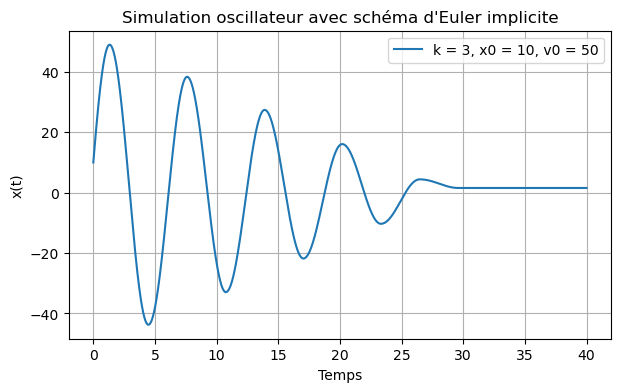

In [9]:

### 2) Simulation numérique

k=3
x0=(10,50)
t0=0
tf=40
dt=0.01

def euler_implicit_friction(x0,t0,tf,dt):
    time=np.arange(t0,tf,dt)
    sol=[x0[0]]
    x=x0
    for t in time[1:]:
        if x[1] - dt*x[0] > k*dt:
            x = (x[0] + dt*x[1], x[1] - dt*x[0] - k*dt)
        elif x[1] - dt*x[0] < -k*dt:
            x = (x[0] + dt*x[1], x[1] - dt*x[0] + k*dt)
        else:
            x = (x[0] + dt*x[1], 0)
        sol.append(x[0])

    return time, sol

time, sol = euler_implicit_friction(x0,t0,tf,dt)
plt.plot(time, sol, label='k = '+str(k)+', x0 = '+str(x0[0])+', v0 = '+str(x0[1]))

plt.xlabel('Temps')
plt.ylabel('x(t)')
plt.title("Simulation oscillateur avec schéma d'Euler implicite")
plt.legend()
plt.grid(True)
